In [2]:
import os
import yaml
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import re


In [7]:
def extract_scalar_from_event_file(event_path, tag):
    ea = EventAccumulator(event_path)
    ea.Reload()

    if tag not in ea.Tags().get("scalars", []):
        return None
    
    print(ea.Tags().get("scalars", []))

    events = ea.Scalars(tag)
    return events[-1].value if events else None

def parse_experiment(logs_dir):
    results = []

    for run_dir in sorted(os.listdir(logs_dir)):
        run_path_base = os.path.join(logs_dir, run_dir)
        
        # Loop through version_* folders
        for subdir in os.listdir(run_path_base):
            if not re.match(r"version_\d+", subdir):
                continue

            run_path = os.path.join(run_path_base, subdir)
            hparam_path = os.path.join(run_path, "hparams.yaml")

            if not os.path.exists(hparam_path):
                continue

            # Load hparams
            with open(hparam_path, "r") as f:
                hparams = yaml.load(f, Loader=yaml.UnsafeLoader)

            # Find event file
            event_files = [f for f in os.listdir(run_path) if f.startswith("events.out.tfevents")]
            if not event_files:
                continue

            event_path = os.path.join(run_path, event_files[0])

            # Pull all the relevant metrics
            metrics = {
                "roi_loss": extract_scalar_from_event_file(event_path, "roi_loss_epoch"),
                "base_loss": extract_scalar_from_event_file(event_path, "base_loss_epoch"),
                "ssim": extract_scalar_from_event_file(event_path, "val_metrics/ssim"),
                "nmse": extract_scalar_from_event_file(event_path, "val_metrics/nmse"),
                "psnr": extract_scalar_from_event_file(event_path, "val_metrics/psnr"),
            }

            results.append({
                "run": run_dir,
                "version": subdir,
                "alpha": hparams.get("alpha"),
                "roi_size": hparams.get("roi_size"),
                **metrics,
            })

    return results

def print_results_table(results):
    # print(f"{'Run':<20} {'Alpha':<7} {'ROI Size':<10} {'ROI Loss':<10} {'Base Loss':<10} {'SSIM':<8} {'NMSE':<8} {'PSNR':<8}")
    print(f"{'Run':<20} {'ROI Loss':<10} {'Base Loss':<10} {'SSIM':<8} {'NMSE':<8} {'PSNR':<8}")
    print("-" * 90)
    for r in results:
        # print(f"{r['run']:<20} {r['alpha']:<7} {r['roi_size']:<10} {r['roi_loss']:<10.4f} {r['base_loss']:<10.4f} {r['ssim']:<8.4f} {r['nmse']:<8.4f} {r['psnr']:<8.4f}")
        try:
            print(f"{r['run']:<20} {r['roi_loss']:<10.4f} {r['base_loss']:<10.4f} {r['ssim']:<8.4f} {r['nmse']:<8.4f} {r['psnr']:<8.4f}")
        except TypeError:
            print(f"can't print {r['run']}")


In [4]:
# results = parse_experiment("roi_unet_checkpoints/logs")
results = parse_experiment("final_logs")

['hp_metric', 'roi_loss_step', 'base_loss_step', 'epoch', 'val_loss', 'validation_loss', 'val_metrics/nmse', 'val_metrics/ssim', 'val_metrics/psnr', 'roi_loss_epoch', 'base_loss_epoch']
['hp_metric', 'roi_loss_step', 'base_loss_step', 'epoch', 'val_loss', 'validation_loss', 'val_metrics/nmse', 'val_metrics/ssim', 'val_metrics/psnr', 'roi_loss_epoch', 'base_loss_epoch']
['hp_metric', 'roi_loss_step', 'base_loss_step', 'epoch', 'val_loss', 'validation_loss', 'val_metrics/nmse', 'val_metrics/ssim', 'val_metrics/psnr', 'roi_loss_epoch', 'base_loss_epoch']
['hp_metric', 'roi_loss_step', 'base_loss_step', 'epoch', 'val_loss', 'validation_loss', 'val_metrics/nmse', 'val_metrics/ssim', 'val_metrics/psnr', 'roi_loss_epoch', 'base_loss_epoch']
['hp_metric', 'roi_loss_step', 'base_loss_step', 'epoch', 'val_loss', 'validation_loss', 'val_metrics/nmse', 'val_metrics/ssim', 'val_metrics/psnr', 'roi_loss_epoch', 'base_loss_epoch']
['hp_metric', 'roi_loss_step', 'base_loss_step', 'epoch', 'val_loss', 

In [5]:
# results

In [8]:
print_results_table(results)

Run                  ROI Loss   Base Loss  SSIM     NMSE     PSNR    
------------------------------------------------------------------------------------------
alpha1.0_roi100_epoch30 0.2775     0.2775     0.7159   0.0366   31.4412 
alpha1.0_roi100_epoch30 0.2691     0.2691     0.7207   0.0345   31.8427 
can't print alpha1.25_roi100_epoch30
alpha1.25_roi100_epoch30 0.2795     0.2724     0.7228   0.0348   31.7801 
alpha1.25_roi100_epoch30 0.2747     0.2677     0.7229   0.0344   31.8703 
can't print alpha1.25_roi100_epoch30


In [9]:
import pandas as pd 

df = pd.DataFrame(results)
df = df.sort_values(by=["ssim", "nmse"], ascending=[False, True])

df

,run,version,alpha,roi_size,roi_loss,base_loss,ssim,nmse,psnr
4,alpha1.25_roi100_epoch30,version_4,1.25,100,0.274723,0.267696,0.722855,0.034420,31.870350
3,alpha1.25_roi100_epoch30,version_2,1.25,100,0.279514,0.272361,0.722821,0.034759,31.780138
1,alpha1.0_roi100_epoch30,version_1,1.00,100,0.269054,0.269054,0.720676,0.034512,31.842722
0,alpha1.0_roi100_epoch30,version_0,1.00,100,0.277502,0.277502,0.715920,0.036592,31.441208
2,alpha1.25_roi100_epoch30,version_0,1.25,100,NaN,NaN,NaN,NaN,NaN
5,alpha1.25_roi100_epoch30,version_6,1.25,100,NaN,NaN,NaN,NaN,NaN


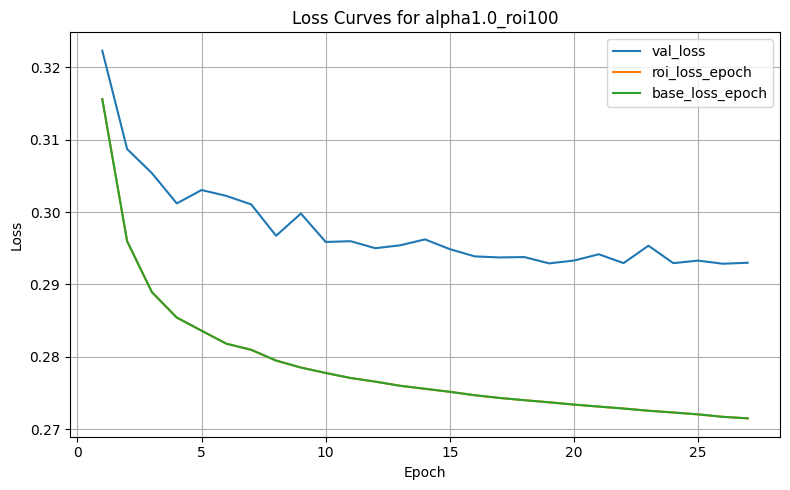

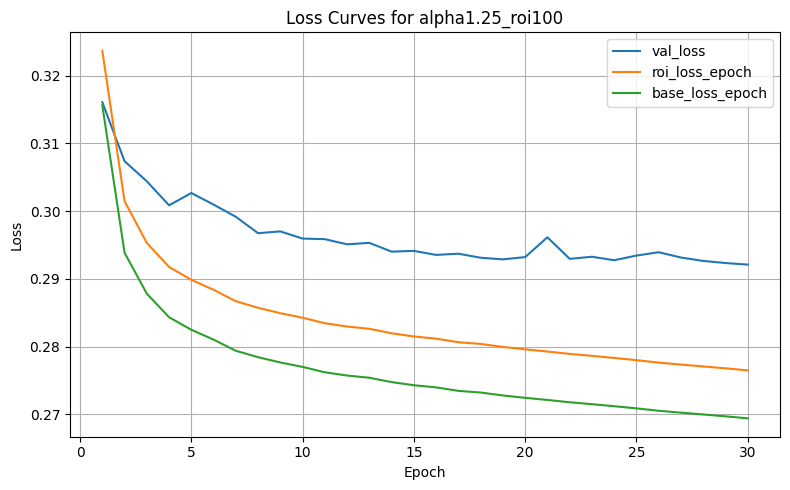

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# The specific runs you want to visualize
target_runs = {
    "alpha1.25_roi100",
    "alpha1.0_roi100"
}

# Tags to plot
tags_to_plot = ["val_loss", "roi_loss_epoch", "base_loss_epoch"]

# Base log dir
logs_dir = "roi_vs_base/logs"

# Loop over each desired run
for run_dir in sorted(target_runs):
    run_path = os.path.join(logs_dir, run_dir, "version_0")
    event_files = [f for f in os.listdir(run_path) if f.startswith("events.out.tfevents")]

    if not event_files:
        print(f"No event file found for {run_dir}")
        continue

    event_path = os.path.join(run_path, event_files[0])
    ea = EventAccumulator(event_path)
    ea.Reload()

    # Start a new figure for this run
    plt.figure(figsize=(8, 5))

    for tag in tags_to_plot:
        if tag not in ea.Tags().get("scalars", []):
            print(f"Tag {tag} not found in {run_dir}")
            continue

        events = ea.Scalars(tag)
        epochs = list(range(1, len(events) + 1))
        values = [e.value for e in events]

        plt.plot(epochs, values, label=tag)

    plt.title(f"Loss Curves for {run_dir}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
